In [179]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/glove-6b-50d/glove.6B.50d.txt


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_data = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_data = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [4]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
train_data.dropna(inplace=True)

In [7]:
train_data['text_length'] = train_data['text'].apply(lambda t : len(t)) 
print(f"The maximum length of a tweet is: {max(train_data['text_length'])}\n")

train_data[train_data['text_length'] == max(train_data['text_length'])]

The maximum length of a tweet is: 141



,textID,text,selected_text,sentiment,text_length
3138,0d64ba9efd,Is so freaking bored on the bus. Hate being po...,bored,negative,141
27318,d370238b6b,just saw an advert for ATTICS TO EDEN on tv o...,just saw an advert for ATTICS TO EDEN on tv o...,neutral,141


In [8]:
train_data['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

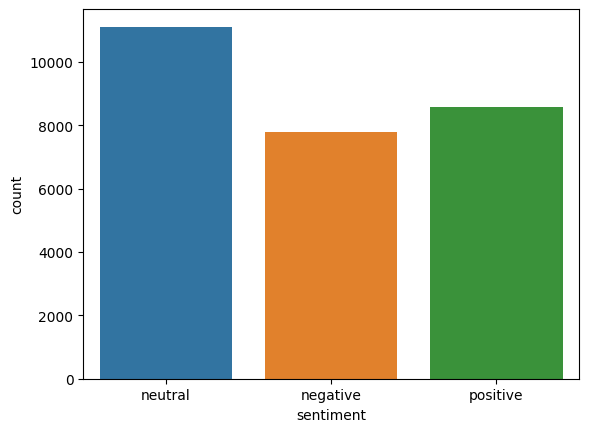

In [9]:
sns.countplot(x='sentiment', data=train_data)

In [70]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors

In [17]:
def load_glove_embeddings(embedding_file):
    embeddings_index = {}
    with open(embedding_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = '/kaggle/input/glove-6b-50d/glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
num_words = len(tokenizer.word_index)+1

In [85]:
X_train = train_data['text']
y_train = train_data['sentiment']

X_test = test_data['text']
y_test = test_data['sentiment']

In [86]:
X_train_mat = tokenizer.texts_to_sequences(X_train)
X_test_mat = tokenizer.texts_to_sequences(X_test)

In [87]:
max_len = 150

In [88]:
X_train_padded = pad_sequences(X_train_mat, maxlen=max_len)
X_test_padded = pad_sequences(X_test_mat, maxlen=max_len)

In [89]:
label_encoder = LabelEncoder()

y_train_labeled = label_encoder.fit_transform(y_train).reshape((-1,1))
y_test_labeled = label_encoder.transform(y_test).reshape((-1,1))

In [90]:
y_train_enc = to_categorical(y_train_labeled)
y_test_enc = to_categorical(y_test_labeled)

In [92]:
print(X_train_padded.shape)
print(y_train_enc.shape)
print(X_test_padded.shape)
print(y_test_enc.shape)

(27480, 150)
(27480, 3)
(3534, 150)
(3534, 3)


In [133]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from keras.regularizers import l2

In [134]:
embedding_dim = 50

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [151]:
def create_LSTM_model(num_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, 
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len, 
                        trainable=False))
    model.add(LSTM(num_units))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(64, input_dim=64, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='softmax'))
    
    model.summary()
    return model

In [152]:
num_units = 32
dropout_rate = 0.5

In [200]:
model = create_LSTM_model(num_units, dropout_rate)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 50)           1329950   
                                                                 
 lstm_12 (LSTM)              (None, 32)                10624     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 3)                 195       
                                                     

In [201]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [202]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [203]:
history = model.fit(X_train_padded, y_train_enc, batch_size=128, epochs=40, validation_split=0.2, verbose=2,
                   callbacks=[early_stopping])

Epoch 1/40
172/172 - 5s - loss: 1.4195 - accuracy: 0.4511 - val_loss: 1.2305 - val_accuracy: 0.5300 - 5s/epoch - 29ms/step
Epoch 2/40
172/172 - 2s - loss: 1.1185 - accuracy: 0.5701 - val_loss: 1.0425 - val_accuracy: 0.5682 - 2s/epoch - 9ms/step
Epoch 3/40
172/172 - 2s - loss: 1.0012 - accuracy: 0.6011 - val_loss: 0.9259 - val_accuracy: 0.6365 - 2s/epoch - 9ms/step
Epoch 4/40
172/172 - 2s - loss: 0.9290 - accuracy: 0.6222 - val_loss: 0.8717 - val_accuracy: 0.6394 - 2s/epoch - 10ms/step
Epoch 5/40
172/172 - 2s - loss: 0.8788 - accuracy: 0.6378 - val_loss: 0.8394 - val_accuracy: 0.6605 - 2s/epoch - 9ms/step
Epoch 6/40
172/172 - 2s - loss: 0.8450 - accuracy: 0.6481 - val_loss: 0.8021 - val_accuracy: 0.6747 - 2s/epoch - 9ms/step
Epoch 7/40
172/172 - 2s - loss: 0.8214 - accuracy: 0.6582 - val_loss: 0.8184 - val_accuracy: 0.6490 - 2s/epoch - 9ms/step
Epoch 8/40
172/172 - 2s - loss: 0.8045 - accuracy: 0.6654 - val_loss: 0.7715 - val_accuracy: 0.6863 - 2s/epoch - 9ms/step
Epoch 9/40
172/172 - 2

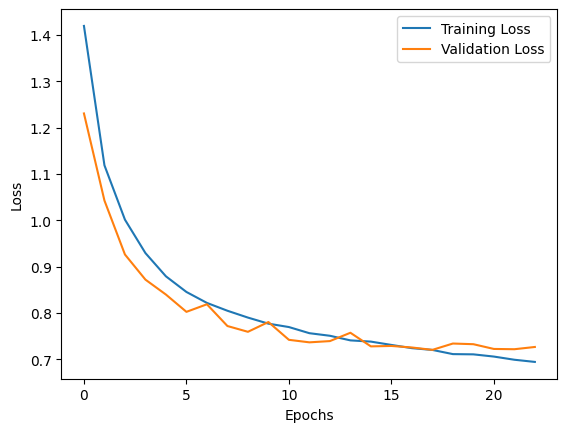

In [204]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [205]:
predictions = model.predict(X_test_padded)

111/111 [==============================] - 1s 4ms/step


In [206]:
predictions  = np.array([np.eye(3)[np.argmax(pred)] for pred in predictions])

In [207]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [208]:
print(accuracy_score(predictions, y_test_enc))

0.6839275608375778


In [209]:
print(confusion_matrix(predictions.argmax(axis=1), y_test_enc.argmax(axis=1)))

[[ 586  201   43]
 [ 347 1007  236]
 [  68  222  824]]


In [210]:
print(classification_report(predictions, y_test_enc))

              precision    recall  f1-score   support

           0       0.59      0.71      0.64       830
           1       0.70      0.63      0.67      1590
           2       0.75      0.74      0.74      1114

   micro avg       0.68      0.68      0.68      3534
   macro avg       0.68      0.69      0.68      3534
weighted avg       0.69      0.68      0.68      3534
 samples avg       0.68      0.68      0.68      3534

